# Applying Principal Component Analysis to Cold Atom Images - Theory
## August 12, 2017
## Hiro Miyake
### Contents
1. [Introduction](#introduction)
2. [Absorption Imaging of Cold Atoms](#absimg)
3. [Introduction to Principal Component Analysis (PCA)](#intropca)
4. [Applying PCA to Absorption Imaging of Cold Atoms](#pcatoatoms)
5. [References](#references)

<a id="introduction"></a>
## 1. Introduction  
In this Jupyter notebook first I will describe how we perform absorption imaging of cold atoms for analysis. This will demonstrate the utility of being able remove some noise from the images, and principal component analysis is well-suited for this task. Then I outline a brief introduction to principal component analysis. Finally, I discuss a few additional considerations in applying principal component analysis (PCA) to absorption images of cold atoms. Take a look at the companion application notebook [here](https://github.com/hiromiyake/DataAnalysisProjects/blob/master/PCAforColdAtomImages/PCAColdAtomImages-Application.ipynb) to see how the ideas described here are applied to real data.

<a id="absimg"></a>
## 2. Absorption Imaging of Cold Atoms
When studying cold atoms, one of the best ways to extract quantitative information is to perform absorption imaging (see [references](#references) for more details).

This is done by briefly (typically of order 10 $\mu$s) shining a pulse of laser light resonant with an atomic transition and collecting that light onto a charge-coupled device (CCD) camera. If the light is resonant to an atomic transition, then where the atoms are present it should look like there is a deficit of light because the atoms absorbed the light there. This CCD image I call the probe with atoms (PWA).

However, discering the presence of atoms from a single image is usually not easy because the light can have non-uniform structure and imperfect optics can obscure the signal. One way to get around this is to take another image as soon as the atoms have left the imaging field with exactly the same laser pulse, but this time without the atoms. This CCD image I call the probe without atoms (PWOA). By taking the ratio of the two images, the inhomogeneities in the image where the atoms do not exist are normalized in theory and the atoms should appear very clearly.

One other step taken is to take a third image, this time without the imaging beam but keeping everything else the same. I call this image the dark field. This image is subtracted from both the PWA and PWOA before their ratio are taken.

So to summarize, we take three cold atom images in a single experimental run, PWA, PWOA, and dark field, and are processed as follows,
\begin{equation}
\text{Absorption} = \frac{\text{PWA} - \text{dark}}{\text{PWOA} - \text{dark}}
\end{equation}

Now let's take a look at actual images to see how this works in reality. First, I load in a few images. Note the images are stores as .ibw files, which is the file format for [IGOR Pro](https://www.wavemetrics.com/products/igorpro/igorpro.htm), a scientific programming software developed by [WaveMetrics](https://www.wavemetrics.com). To read these into Python, I use the open-source IGOR Python module obtainable from [here](https://pypi.python.org/pypi/igor).

In [1]:
%matplotlib inline
#%pylab inline
#pylab.rcParams['figure.figsize'] = (10, 6)

from __future__ import division
import numpy as np
import igor.binarywave as bw
import matplotlib.pyplot as plt
import os
import coldatomimages_v1 as coldatomimages

In [2]:
direct = '/Users/hiro/Documents/data-science/python/pca/ibw_files' ## For Mac
#direct = 'C:\Users\Hiro\Documents\code\pca\data\images170405' ## For Windows
filenames = os.listdir(direct)

filenames_ibw = []
for i in filenames:
    if i[-3:] == 'ibw':
        filenames_ibw.append(direct+'/'+i) ## For Mac
        #filenames_ibw.append(direct+'\\'+i) ## For Windows

imagelist = []
firstimage = True
for i in filenames_ibw:
    ## x is a dictionary with keys 'version' and 'wave'
    ## The value of 'wave' is in turn a dictionary
    x = bw.load(i)
    
    ## 'wData' contains the images
    ## This is a numpy array that has size 3 Ny x Nx
    ## This is a stack of 3 images
    ## Grasshopper has image size 1928 x 1448 pixels
    xwave = x['wave']
    imagestack = xwave['wData']
    imagestack = np.matrix(imagestack)
    
    if firstimage:
        stacksize = imagestack.shape
        imagesize = []
        imagesize.append(stacksize[0]/3)
        imagesize.append(stacksize[1])
        firstimage = False
    
    ## Chop the super-image into 3 images
    ipwa = imagestack[:imagesize[0]].T
    ipwoa = imagestack[imagesize[0]:imagesize[0]*2].T
    idark = imagestack[imagesize[0]*2:].T
    imageset = []
    imageset.append(ipwa)
    imageset.append(ipwoa)
    imageset.append(idark)
    imagelist.append(imageset)

/Users/hiro/anaconda/lib/python2.7/site-packages/numpy/matrixlib/defmatrix.py:318: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out = N.ndarray.__getitem__(self, index)


Now that the images are loaded into a Python list, I can load that into the `coldAtomImages` object I have written to start to look at some of the images. The object's full functionality will be explored in more depth in the companion 'application' notebook.

In [3]:
## Create coldAtomImages object with imagelist
myImageSet = coldatomimages.coldAtomImages(imagelist)
## Get the first image in the list
firstImage = myImageSet.getImageList()[0]

First, let's take a look at the PWA of one image.

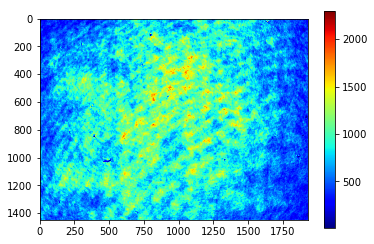

In [4]:
## Plot the probe with atoms (PWA) CCD image
plt.imshow(firstImage[0], cmap='jet')
plt.colorbar()

It's not obvious at all that there are atoms somewhere in this image.

There are fringes, but actually this is not necessarily a problem, since if those same fringes appear in the PWOA image, then by dividing the two, the fringes will be normalized and will look flat.

Now let's look at the PWOA of that image.

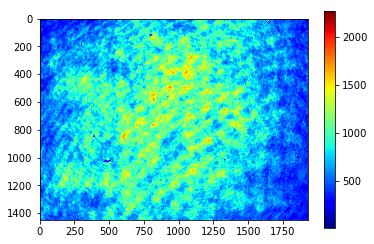

In [5]:
## Plot the probe without atoms (PWOA) CCD image
plt.imshow(firstImage[1], cmap='jet')
plt.colorbar()

The PWA and PWOA images look very similar.

Now let's look at the dark field image.

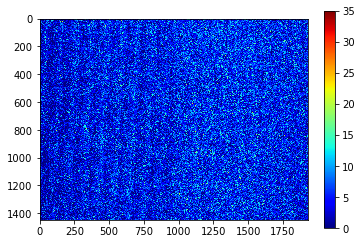

In [6]:
## Plot the dark field CCD image
plt.imshow(firstImage[2], cmap='jet')
plt.colorbar()

Not much is going on in the dark field image.

Now, let's subtract the dark field from PWA and PWOA, and take the ratio of them.

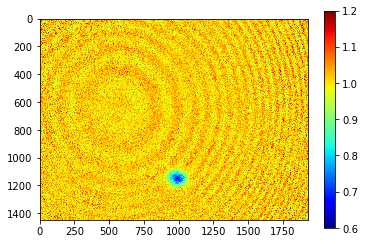

In [7]:
colorlim=(0.6,1.2) ## Set the color scale limits
plt.imshow(np.true_divide(firstImage[0]-firstImage[2], firstImage[1]-firstImage[2]), cmap='jet', clim = colorlim)
plt.colorbar()

Voila! Now we see the atoms. Now we are in a position to do quantitative analysis on these atoms.

However, note that we see some rings in the image most likely not directly related to the atoms. Such fringes can obscure the actual signal we are looking for in the atoms. It would be ideal if we can remove such fringes. That is where principal component analysis comes in.

Note that the rings are not present just because the imaging beam has fringes or inhomogeneities. If the PWA and PWOA lights are the same, then such fringes should be canceled out when we divide the PWA and PWOA images. Therefore, these fringes must come from the fact that the camera is not seeing the same light in the PWA and PWOA steps, possibly becuase of time-dependent mechanical displacements, air currents, or other such temporal disturbances.

Therefore, what we want to do is not necessarily remove all fringes from each of the PWA and PWOA images, but to remove the shot-to-shot variation in the PWA and PWOA images. One way to do this is to assume that for all of the images, there is some average PWA and PWOA image which is invariant from shot-to-shot. Then on top of that invariant image are added shot-dependent variations on the image. PCA will allow us to determine this shot-dependent variation in the images.

<a id="intropca"></a>
## 2. Introduction to Principal Component Analysis (PCA)
Before we apply PCA to cold atom absorption images, let us understand what PCA is and how it works. There are some nice [references](#references) on this online.

In words, PCA is a method to determine the orthogonal directions that the data varies in decreasing order.

Practically, let $\textbf{X}$ be an $n \times p$ matrix, where the columns are the different variables, and the rows are the different observations. First, you determine the mean of each column and subtract that from each entry in the column. Let's call the $n \times p$ matrix which has the mean of each column in each entry of the column $\overline{\textbf{X}}$. Then we construct the covariance matrix of this as $\textbf{C} = \frac{1}{n-1}(\textbf{X} - \overline{\textbf{X}})^T(\textbf{X} - \overline{\textbf{X}})$. Then the eigenvectors of the matrix $\textbf{C}$ are the principal components, and the relative magnitude of the eigenvalues indicate the importance of the corresponding principal compoment.

Applied to our situation, the columns correspond to different pixels of the images, and the rows correspond to different images.

Let's see how this works by focusing on just two pixels in the set of images we have. In this case we have 16 images. Then we effectively have a dataset where we have 2 columns and 16 rows. We can plot these 16 data points in two-dimensional space.

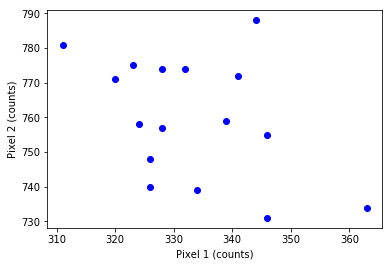

In [16]:
pixel1, pixel2 = [], []
for i in myImageSet.getImageList():
    pixel1.append(i[1][0,0])
    pixel2.append(i[1][400,400])

plt.plot(pixel1, pixel2, 'bo')
plt.xlabel('Pixel 1 (counts)')
plt.ylabel('Pixel 2 (counts)')

The procedue is to subtract the mean from each of these two dimensions. Note this is just a shifting of the data points in 2D.

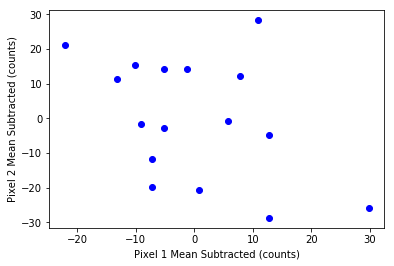

In [18]:
p1mean = np.mean(pixel1)
p2mean = np.mean(pixel2)

p1norm = list(pixel1)
p2norm = list(pixel2)

for i in xrange(len(p1norm)):
    p1norm[i] = p1norm[i] - p1mean
    p2norm[i] = p2norm[i] - p2mean

plt.plot(p1norm, p2norm, 'bo')
plt.xlabel('Pixel 1 Mean Subtracted (counts)')
plt.ylabel('Pixel 2 Mean Subtracted (counts)')

We see that the data are scattered, but there appears to be a trend in the data where the two pixel counts are negatively correlated, i.e., when pixel 1 increases in count, pixel 2 decreases in count. We can then imagine re-expressing this data by rotating it so that the direction in which the data varies the most is the first principal axis, and then the orthogonal direction is the second principal axis. What PCA allows us to do is to determine the direction of the principal components. This is done below by constructing the covariance matrix and then finding the eigenvalues and eigenvectors.

[ 1742.16139541  5347.27610459]
[[-0.89763848  0.44073253]
 [-0.44073253 -0.89763848]]


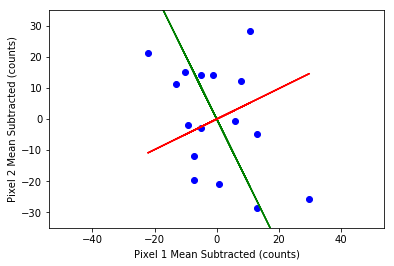

In [65]:
parray = np.array([p1norm,p2norm])
covmat = np.dot(parray,parray.T)
eigval,eigvecs = np.linalg.eig(covmat)

print eigval
print eigvecs

## Note the columns of the eigenvector matrix are the principal components
## Note that the second eigenvalue is the larger one
## This means that the second column is the first principal component
line1 = np.multiply(eigvecs[1,1]/eigvecs[0,1], p1norm)
line2 = np.multiply(eigvecs[1,0]/eigvecs[0,0], p1norm)

plt.xlabel('Pixel 1 Mean Subtracted (counts)')
plt.ylabel('Pixel 2 Mean Subtracted (counts)')
plt.axis('equal')
plt.axis([-35, 35, -35, 35])
plt.plot(p1norm, p2norm, 'bo', p1norm, line1, 'g-', p1norm, line2, 'r-')

The lines represent the two principcal component directions. Indeed, they look sensible.

We can actually do the same thing more directly and easily with the `pca` module in Scikit-learn.

[[ 0.44073253 -0.89763848]
 [ 0.89763848  0.44073253]]


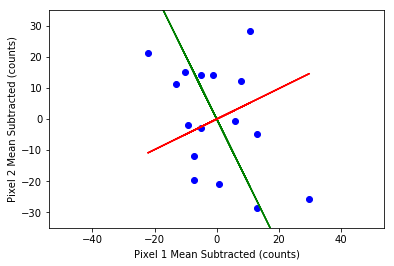

In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(parray.T)
pca_bases = pca.components_

print pca_bases

## Note in this case that the first row is the first principal component
## The second row is the second principal component
line1pca = np.multiply(pca_bases[0,1]/pca_bases[0,0], p1norm)
line2pca = np.multiply(pca_bases[1,1]/pca_bases[1,0], p1norm)

plt.xlabel('Pixel 1 Mean Subtracted (counts)')
plt.ylabel('Pixel 2 Mean Subtracted (counts)')
plt.axis('equal')
plt.axis([-35, 35, -35, 35])
plt.plot(p1norm, p2norm, 'bo', p1norm, line1pca, 'g-', p1norm, line2pca, 'r-')

Note that because we are only looking at two pixels, we only have two principal components. In the actual situation we have, we have many more pixels than the number of images. In such a case, we will have only up to the number of images of principal components which are unique and useful to us.

Also note that PCA works well when the data are distributed in a Gaussian way. If the data is distributed in some other way, say in a ring shape, then decomposing the data into orthonormal bases will not simplify the data. In such a situation, it can make sense to apply a nonlinear transformation first, and then apply PCA. Another technique that can work in such a situation is the indepenent component analysis (ICA) method, but that is beyond the scope of this notebook.

So to summarize, PCA allows us to determine the bases in which the data varies strongest in a systematic way.

<a id="pcatoatoms"></a>
## 4. Applying PCA to Absorption Imaging of Cold Atoms
Let us come back to the original purpose of applying PCA to absorption imaging of cold atoms. We had fringes in our images which we wanted to get rid of. We attributed this to shot-to-shot variations in the imaging beam pattern on the camera due to for example mechanical vibrations or air currents. PCA is one method that should allow us to do this. How exactly do we apply PCA for this purpose?

### 4.1. Applying PCA to PWOA Images
Let us consider the PWOA image first, since this is the simpler case since there are no atoms to worry about. What we are assuming is that there is a mean PWOA image, let's call this mean image $\textbf{p}_0$, which can also be thought of as a matrix or vector depending on the situation. Then for each image, there is the mean image to start off with, but then there is 'noise' added on top of that mean image. With PCA, what we are trying to do is to determine the bases which make up this noise. Essentially we are assuming that there are only a few noise archetypes (in the form of bases) which are imprinted on each image. Let's write the principal components of the PWOA as $\textbf{p}_1,\textbf{p}_2,\ldots$, such that each PWOA image $\textbf{I}_{\rm PWOA}$ can be written as
$$
\begin{equation}
\textbf{I}_{\rm PWOA} = \textbf{p}_0 + a_1 \textbf{p}_1 + + a_2 \textbf{p}_2 + \cdots,
\end{equation}
$$
where the $a_i$'s are image-dependent weights of the noise bases. Now we can see what cleaning the fringes mean mathematically. We can rearrange the terms to get just the presumably invariant mean image $\textbf{p}_0$ as
$$
\begin{equation}
\textbf{p}_0 = \textbf{I}_{\rm PWOA} - a_1 \textbf{p}_1 - a_2 \textbf{p}_2 - \cdots.
\end{equation}
$$
Now all we need to do is to find the value for each of the weights $a_i$'s and we can perform this subtraction. The orthonormality of the principal components work very nicely here. For example, if you wanted to know what $a_1$ is, then using the orthonormality of the $\textbf{p}_i$'s, we get that
$$
\begin{equation}
a_1 = (\textbf{I}_{\rm PWOA} - \textbf{p}_0) \cdot \textbf{p}_1.
\end{equation}
$$
With this, we can write the fringe-corrected PWOA image $\textbf{I}'_{\rm PWOA}$ as
$$
\begin{equation}
\textbf{I}'_{\rm PWOA} = \textbf{I}_{\rm PWOA} - \sum_{i=1} \left[(\textbf{I}_{\rm PWOA} - \textbf{p}_0) \cdot \textbf{p}_i \right] \textbf{p}_i
\end{equation}
$$

### 4.2. Applying PCA to PWA Images
At this point, there are two ways to deal with the fringes in the PWA images. One is to subtract them from the PWA image itself, and the other is to 'reimprint' the fringe in the PWA image onto the PWOA image. The distinction comes from whether the fringes are caused by factors after or before the light hits the atoms, respectively. Practically, you should examine how the images look to determine which is the better approach, since there is no 'ground truth' in this situation. Let's start by considering the case if the fringes are caused by events after the light hits the atoms.

#### 4.2.1. Post-Atom Fringes
If the fringes are caused by events after passing through the atoms, the fringes should be subtracted from both PWA and PWOA images. We have already shown how to subtract the fringes in the PWOA images with the principal components found with the PWOA images. If we assume that the fringes appearing in the PWA images are the same type as appearing in the PWOA images, then we can use the principal components found with the PWOA images to subtract the fringes from the PWA images.

However, there is one complication. There are atoms present in the PWA atoms, and we don't want the principal components to 'see' this when performing the subtraction. One way to avoid this is to decompose the PWA atoms into two parts such that $\textbf{I}_{\rm PWA} = \textbf{I}^-_{\rm PWA} + \textbf{I}^0_{\rm PWA}$, where by defining a region around the atoms where we want to 'mask' the atoms, $\textbf{I}^-_{\rm PWA}$ is the PWA image where the mask region is set to zero, and $\textbf{I}^0_{\rm PWA}$ is the PWA image where everywhere outside of the mask region has been set to zero. With this modification, following the same argument as for determining the fringe-corrected PWOA image, we determine the fringe-corrected PWA image $\textbf{I}'_{\rm PWA}$ as
$$
\begin{equation}
\textbf{I}'_{\rm PWA} = \textbf{I}_{\rm PWA} - \sum_{i=1} \left[(\textbf{I}^-_{\rm PWA} - \textbf{p}_0) \cdot \textbf{p}_i \right] \textbf{p}_i.
\end{equation}
$$

Recall also from our calculation above that
$$
\begin{equation}
\textbf{I}'_{\rm PWOA} = \textbf{I}_{\rm PWOA} - \sum_{i=1} \left[(\textbf{I}_{\rm PWOA} - \textbf{p}_0) \cdot \textbf{p}_i \right] \textbf{p}_i.
\end{equation}
$$

Putting all of these together, the fringe-corrected absorption image is given as
$$
\begin{equation}
\textbf{I}_{\rm Abs} = \frac{\textbf{I}'_{\rm PWA} - \textbf{I}_{\rm dark}}{\textbf{I}'_{\rm PWOA} - \textbf{I}_{\rm dark}}.
\end{equation}
$$

#### 4.2.2. Pre-Atom Fringes
If the fringes are caused by events before hitting the atoms, then we must take into account the fact that the imaging beam and the fringes where the atoms are will be attenuated by the atoms due to absorption, and so basing the fringe subtraction where the atoms exist on fringes outside of the mask region will tend to oversubtract the fringes inside the mask. This can be addressed by adding the fringe in the PWA image onto the PWOA image. Specifically, this can be done in the following way.

We can take the principal components $\textbf{p}_i$'s we found with the PWOA images and decompose them as $\textbf{p}_i = \textbf{p}^-_i + \textbf{p}^0_i$, where just as in the post-atom fringe case above, $\textbf{p}^-_i$ is the principal component where the mask region is set to zero, and $\textbf{p}^0_i$ is the principal component where everywhere outside of the mask region has been set to zero. Then we can take $\textbf{p}^-_i$ and renormalize it to define a new 'basis' $\textbf{p}'_i$ (which is not really a basis anymore since they will most likely not be orthonormal) such that
$$
\begin{equation}
\textbf{p}'_i = \frac{1}{\sqrt{\textbf{p}^-_i \cdot \textbf{p}^-_i}} \textbf{p}^-_i.
\end{equation}
$$
With this definition, we can get the principal component coefficients $a_i$'s for the PWA by
$$
\begin{equation}
a_i = (\textbf{I}_{\rm PWA} - \textbf{p}_0) \cdot \textbf{p}'_i.
\end{equation}
$$

Then, we can take these coefficients and add the PWA fringes back onto the PWOA images as such
Recall also from our calculation above that
$$
\begin{equation}
\textbf{I}''_{\rm PWOA} = \textbf{I}_{\rm PWOA} - \sum_{i=1} \left[(\textbf{I}_{\rm PWOA} - \textbf{p}_0) \cdot \textbf{p}_i \right] \textbf{p}_i + \sum_{i=1} \left[ (\textbf{I}_{\rm PWA} - \textbf{p}_0) \cdot \frac{1}{\sqrt{\textbf{p}^-_i \cdot \textbf{p}^-_i}} \textbf{p}^-_i \right] \textbf{p}_i.
\end{equation}
$$

Putting all of this together, we get the absorption image as
$$
\begin{equation}
\textbf{I}_{\rm Abs} = \frac{\textbf{I}_{\rm PWA} - \textbf{I}_{\rm dark}}{\textbf{I}''_{\rm PWOA} - \textbf{I}_{\rm dark}}.
\end{equation}
$$

### 4.3. Limitations on Applying PCA to Fringe Subtraction
There are some limitations in this method of subtracting fringes.
1. We assume the principal components for the fringes are the same in both PWA and PWOA images.
2. We assume the noise is Gaussian distributed.
If these assumptions are violated, then our fringe subtraction may not be effective.

In the [companion notebook](https://github.com/hiromiyake/DataAnalysisProjects/blob/master/PCAforColdAtomImages/PCAColdAtomImages-Application.ipynb), I will show how this fringe subtraction method works in practice with real data.

<a id="references"></a>
## 5. References
1. W. Ketterle, D. S. Durfee, and D. M. Stamper-Kurn, Making, probing and understanding Bose-Einstein condensates, [arXiv:cond-mat/9904034](https://arxiv.org/abs/cond-mat/9904034) (1999).
2. L. I. Smith, A Tutorial on Principal Components Analysis, http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf, February 26, 2002.
3. J. Shlens, A Tutorial on Principal Component Analysis, [arXiv:1404.1100 [cs.LG]](https://arxiv.org/abs/1404.1100), (2014).